In [2]:
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryConfusionMatrix

import numpy as np
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load dataset

In [4]:
dataset = load_dataset("imdb", cache_dir='./data')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Preprocessing

In [5]:
split_Dataset = dataset['train'].train_test_split(test_size=0.2)

train = split_Dataset['train']
val = split_Dataset['test']
test = dataset['test']

In [6]:
X_train, y_train = train['text'], train['label']
X_val, y_val = val['text'], val['label']
X_test, y_test = test['text'], test['label']

#### Remove html scripts, square brackets & special character

In [7]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text

In [8]:
X_train = [clean_text(text) for text in X_train]
X_val   = [clean_text(text) for text in X_val]
X_test  = [clean_text(text) for text in X_test]

### Tokenize

In [9]:
X_train_tokenized = [[token for token in word_tokenize(text.lower())] for text in X_train]
X_val_tokenized = [[token for token in word_tokenize(text.lower())] for text in X_val]
X_test_tokenized = [[token for token in word_tokenize(text.lower())] for text in X_test]

In [10]:
print(X_train[0])
print(X_train_tokenized[0])

The world is a terrible place But this movie is farce and its fun And if you dont like it you dont get it and if you dont get it doesnt matter Its up to you if you want to play along Every actor in this one had fun Its only a joke And thats good enough for me Gabriel Byrne is priceless Byrne and Paul Anka doing MY WAY is as Vic puts it the best version ever Okay its no masterpiece but its not bad I was warned against seeing it but Im sure glad I did
['the', 'world', 'is', 'a', 'terrible', 'place', 'but', 'this', 'movie', 'is', 'farce', 'and', 'its', 'fun', 'and', 'if', 'you', 'dont', 'like', 'it', 'you', 'dont', 'get', 'it', 'and', 'if', 'you', 'dont', 'get', 'it', 'doesnt', 'matter', 'its', 'up', 'to', 'you', 'if', 'you', 'want', 'to', 'play', 'along', 'every', 'actor', 'in', 'this', 'one', 'had', 'fun', 'its', 'only', 'a', 'joke', 'and', 'thats', 'good', 'enough', 'for', 'me', 'gabriel', 'byrne', 'is', 'priceless', 'byrne', 'and', 'paul', 'anka', 'doing', 'my', 'way', 'is', 'as', 'vi

### Delete stopwords

In [11]:
stopword_list = stopwords.words('english')
print(stopword_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [12]:
X_train_cleaned = [[token for token in text if token not in stopword_list]for text in X_train_tokenized]
X_val_cleaned = [[token for token in text if token not in stopword_list]for text in X_val_tokenized]
X_test_cleaned = [[token for token in text if token not in stopword_list]for text in X_test_tokenized]

In [13]:
print(X_train[0])
print(X_train_cleaned[0])

The world is a terrible place But this movie is farce and its fun And if you dont like it you dont get it and if you dont get it doesnt matter Its up to you if you want to play along Every actor in this one had fun Its only a joke And thats good enough for me Gabriel Byrne is priceless Byrne and Paul Anka doing MY WAY is as Vic puts it the best version ever Okay its no masterpiece but its not bad I was warned against seeing it but Im sure glad I did
['world', 'terrible', 'place', 'movie', 'farce', 'fun', 'dont', 'like', 'dont', 'get', 'dont', 'get', 'doesnt', 'matter', 'want', 'play', 'along', 'every', 'actor', 'one', 'fun', 'joke', 'thats', 'good', 'enough', 'gabriel', 'byrne', 'priceless', 'byrne', 'paul', 'anka', 'way', 'vic', 'puts', 'best', 'version', 'ever', 'okay', 'masterpiece', 'bad', 'warned', 'seeing', 'im', 'sure', 'glad']


### Lemmatize 

In [14]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag) :
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [15]:
X_train_lemmatized = [[lemmatizer.lemmatize(token, get_wordnet_pos(pos))for token, pos in pos_tag(text)]for text in X_train_cleaned]
X_val_lemmatized = [[lemmatizer.lemmatize(token, get_wordnet_pos(pos))for token, pos in pos_tag(text)]for text in X_val_cleaned]
X_test_lemmatized = [[lemmatizer.lemmatize(token, get_wordnet_pos(pos))for token, pos in pos_tag(text)]for text in X_test_cleaned]

In [16]:
print(X_train[0])
print(X_train_lemmatized[0])

The world is a terrible place But this movie is farce and its fun And if you dont like it you dont get it and if you dont get it doesnt matter Its up to you if you want to play along Every actor in this one had fun Its only a joke And thats good enough for me Gabriel Byrne is priceless Byrne and Paul Anka doing MY WAY is as Vic puts it the best version ever Okay its no masterpiece but its not bad I was warned against seeing it but Im sure glad I did
['world', 'terrible', 'place', 'movie', 'farce', 'fun', 'dont', 'like', 'dont', 'get', 'dont', 'get', 'doesnt', 'matter', 'want', 'play', 'along', 'every', 'actor', 'one', 'fun', 'joke', 'thats', 'good', 'enough', 'gabriel', 'byrne', 'priceless', 'byrne', 'paul', 'anka', 'way', 'vic', 'put', 'best', 'version', 'ever', 'okay', 'masterpiece', 'bad', 'warn', 'see', 'im', 'sure', 'glad']


In [17]:
X_train_str = [' '.join(tokens) for tokens in X_train_lemmatized]
X_val_str = [' '.join(tokens) for tokens in X_val_lemmatized]
X_test_str = [' '.join(tokens) for tokens in X_test_lemmatized]

In [18]:
X_train_str[0]

'world terrible place movie farce fun dont like dont get dont get doesnt matter want play along every actor one fun joke thats good enough gabriel byrne priceless byrne paul anka way vic put best version ever okay masterpiece bad warn see im sure glad'

### TFidf

In [19]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train_str)
X_val_tfidf = vectorizer.transform(X_val_str)
X_test_tfidf = vectorizer.transform(X_test_str)

#### Convert to tensor

In [20]:
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Dataloader

In [21]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

#### MLP model

In [22]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

In [23]:
model1 = MLP(input_dim=5000).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model1.parameters(), lr=0.001)

### train model

In [24]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

In [25]:
for epoch in range(5):
    model1.train()
    total_loss = 0

    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{5} [Training]', leave=False)
    for text, label in train_loop:
        text, label = text.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model1(text)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    model1.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{5} [Validation]", leave=False)
        for text, label in val_loop:
            text, label = text.to(device), label.to(device)

            outputs = model1(text)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            accuracy_metric.update(preds, label)
            f1_metric.update(preds, label)

            val_loop.set_postfix(loss=loss.item())
    val_acc = accuracy_metric.compute().item()
    val_f1 = f1_metric.compute().item()

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

[Epoch 1] Train Loss: 225.2679 || Val Loss: 43.9643 | Acc: 0.8846 | F1: 0.8846


[Epoch 2] Train Loss: 140.5007 || Val Loss: 47.5858 | Acc: 0.8776 | F1: 0.8801


[Epoch 3] Train Loss: 105.0829 || Val Loss: 53.5039 | Acc: 0.8728 | F1: 0.8707


[Epoch 4] Train Loss: 70.0323 || Val Loss: 62.3517 | Acc: 0.8648 | F1: 0.8617


[Epoch 5] Train Loss: 40.3958 || Val Loss: 75.8446 | Acc: 0.8676 | F1: 0.8698


### Test

In [26]:
def creat_heatmap(confusion_matrix) :
    plt.figure(figsize=(12, 7))
    sns.heatmap(confusion_matrix.compute().to('cpu'),
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                linewidths=0.5, 
                square=True, 
                cbar_kws={"shrink": 0.75},

    )


    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

test F1 : 0.8518739938735962
test acc : 0.8512399792671204


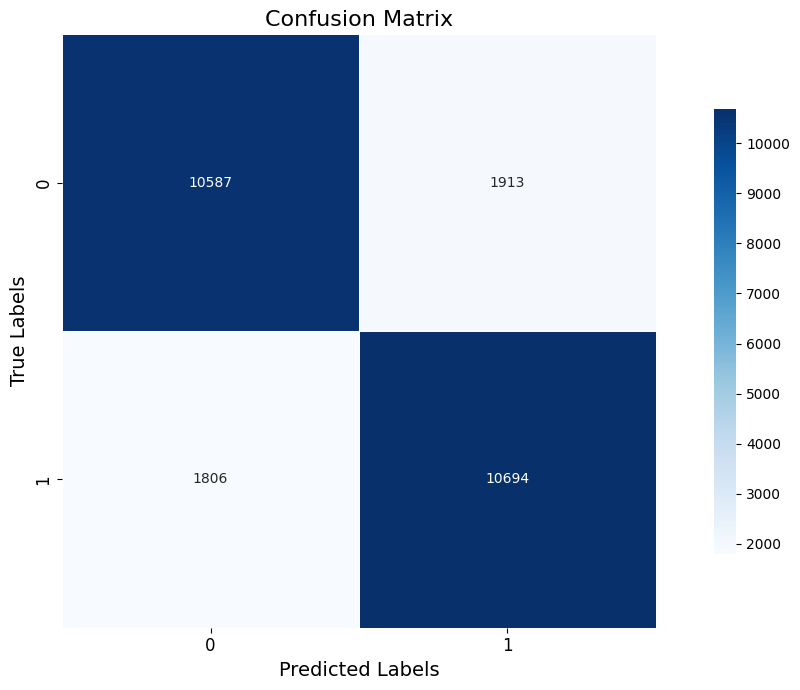

In [27]:
accuracy_metric_test = BinaryAccuracy().to(device)
f1_metric_test = BinaryF1Score().to(device)
CF = BinaryConfusionMatrix().to(device)

with torch.no_grad() :
    for text, label in test_loader:
        text, label = text.to(device), label.to(device)

        outputs = model1(text)
        loss = criterion(outputs, label)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        accuracy_metric_test.update(preds, label)
        f1_metric_test.update(preds, label)
        CF.update(preds, label)

print(f"test F1 : {f1_metric_test.compute().item()}\ntest acc : {accuracy_metric_test.compute().item()}" )
creat_heatmap(CF)

### Save model

In [28]:
torch.save(model1.state_dict(), "./models/tfidf.pt")

### BagofWords

In [29]:
vectorizer_BOW = CountVectorizer(max_features=5000)

X_train_BOW = vectorizer_BOW.fit_transform(X_train_str)
X_val_BOW = vectorizer_BOW.transform(X_val_str)
X_test_BOW = vectorizer_BOW.transform(X_test_str)

#### Convert to tensor

In [30]:
X_train_tensor = torch.tensor(X_train_BOW.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_BOW.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_BOW.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Dataloader

In [31]:
train_dataset_BOW = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_BOW = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_BOW = TensorDataset(X_test_tensor, y_test_tensor)

train_loader_BOW = DataLoader(train_dataset_BOW, batch_size=32, shuffle=True)
val_loader_BOW = DataLoader(val_dataset_BOW, batch_size=32)
test_loader_BOW = DataLoader(test_dataset_BOW, batch_size=32)

### Train

In [32]:
model_BOW = MLP(input_dim=5000).to(device)

criterion_BOW = nn.BCEWithLogitsLoss()
optimizer_BOW = optim.AdamW(model_BOW.parameters(), lr=0.001)

In [33]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

for epoch in range(5):
    model_BOW.train()
    total_loss = 0

    train_loop = tqdm(train_loader_BOW, desc=f'Epoch {epoch+1}/{5} [Training]', leave=False)
    for text, label in train_loop:
        text, label = text.to(device), label.to(device)

        optimizer_BOW.zero_grad()
        outputs = model_BOW(text)
        loss = criterion_BOW(outputs, label)
        loss.backward()
        optimizer_BOW.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    model_BOW.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_loader_BOW, desc=f"Epoch {epoch+1}/{5} [Validation]", leave=False)
        for text, label in val_loop:
            text, label = text.to(device), label.to(device)

            outputs = model_BOW(text)
            loss = criterion_BOW(outputs, label)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            accuracy_metric.update(preds, label)
            f1_metric.update(preds, label)

            val_loop.set_postfix(loss=loss.item())
    val_acc = accuracy_metric.compute().item()
    val_f1 = f1_metric.compute().item()

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

[Epoch 1] Train Loss: 232.5238 || Val Loss: 45.8816 | Acc: 0.8814 | F1: 0.8822


[Epoch 2] Train Loss: 147.8860 || Val Loss: 48.3600 | Acc: 0.8788 | F1: 0.8781


[Epoch 3] Train Loss: 99.7652 || Val Loss: 54.6962 | Acc: 0.8740 | F1: 0.8747


[Epoch 4] Train Loss: 59.6355 || Val Loss: 66.9477 | Acc: 0.8764 | F1: 0.8765


[Epoch 5] Train Loss: 35.8603 || Val Loss: 83.3197 | Acc: 0.8682 | F1: 0.8681


- Better than TFidf model on train and validation

### Test

test F1 : 0.8537333011627197
test acc : 0.8568400144577026


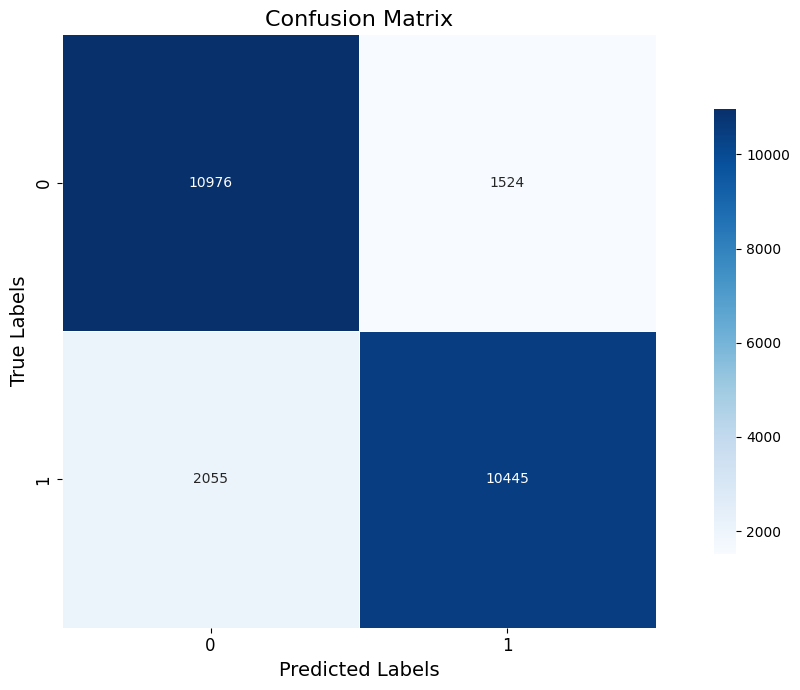

In [34]:
accuracy_metric_test = BinaryAccuracy().to(device)
f1_metric_test = BinaryF1Score().to(device)
CF = BinaryConfusionMatrix().to(device)

with torch.no_grad() :
    for text, label in test_loader_BOW:
        text, label = text.to(device), label.to(device)

        outputs = model_BOW(text)
        loss = criterion_BOW(outputs, label)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        accuracy_metric_test.update(preds, label)
        f1_metric_test.update(preds, label)
        CF.update(preds, label)

print(f"test F1 : {f1_metric_test.compute().item()}\ntest acc : {accuracy_metric_test.compute().item()}" )
creat_heatmap(CF)

In [35]:
torch.save(model1.state_dict(), "./models/BOW.pt")

### GLoVe

#### Load

In [36]:
glove_path = "./data/GLoVe/glove.6B.100d.txt"
glove_cache = './glove/glove_cache.npy'
embedding_dim = 100

word2vec = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

#### Vocab and embedding

In [72]:
word2idx = {"<PAD>": 0, "<UNK>": 1}
idx = 2
for tokens in X_train_lemmatized:
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

In [73]:
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in word2idx.items():
    vec = word2vec.get(word)
    if vec is not None:
        embedding_matrix[i] = vec
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [74]:
X_train_indices = [[word2idx.get(word, word2idx["<UNK>"]) for word in review] for review in X_train_lemmatized ]
X_val_indices = [[word2idx.get(word, word2idx["<UNK>"]) for word in review] for review in X_val_lemmatized ]
X_test_indices = [[word2idx.get(word, word2idx["<UNK>"]) for word in review] for review in X_test_lemmatized ]

#### pad sequences

In [75]:
X_train_tensor = pad_sequence(
    [torch.tensor(seq) for seq in X_train_indices],
    batch_first=True,
    padding_value=word2idx["<PAD>"]
)

X_val_tensor = pad_sequence(
    [torch.tensor(seq) for seq in X_val_indices],
    batch_first=True,
    padding_value=word2idx["<PAD>"]
)

X_test_tensor = pad_sequence(
    [torch.tensor(seq) for seq in X_test_indices],
    batch_first=True,
    padding_value=word2idx["<PAD>"]
)

### Dataloader

In [76]:
train_dataset_G = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_G = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_G = TensorDataset(X_test_tensor, y_test_tensor)

train_loader_G = DataLoader(train_dataset_G, batch_size=32, shuffle=True)
val_loader_G = DataLoader(val_dataset_G, batch_size=32)
test_loader_G = DataLoader(test_dataset_G, batch_size=32)

### Model

In [81]:
class Text_classifier(nn.Module) :
    def __init__(self, embedding_matrix, hidden_dim = 128):
        super().__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.FC = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        avg_emb = embedded.mean(dim=1)
        return self.FC(avg_emb).squeeze()

In [82]:
model_GLove = Text_classifier(embedding_matrix).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_GLoVe = optim.AdamW(model_GLove.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer_GLoVe, step_size=10, gamma=0.5)

### Training

In [83]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 10
counter = 0

for epoch in range(30):
    model_GLove.train()
    total_loss = 0

    train_loop = tqdm(train_loader_G, desc=f'Epoch {epoch+1}/{30} [Training]', leave=False)
    for text, label in train_loop:
        text, label = text.to(device), label.to(device)

        optimizer_GLoVe.zero_grad()
        outputs = model_GLove(text)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer_GLoVe.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    model_GLove.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_loader_G, desc=f"Epoch {epoch+1}/{30} [Validation]", leave=False)
        for text, label in val_loop:
            text, label = text.to(device), label.to(device)

            outputs = model_GLove(text)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            accuracy_metric.update(preds, label)
            f1_metric.update(preds, label)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(model_GLove.state_dict(), "./models/GLoVe.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break

    scheduler.step()


Epoch 1/30 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 340.5047 || Val Loss: 46.3018 | Acc: 0.8804 | F1: 0.8770
Best model saved at epoch 1 with F1: 0.8770


[Epoch 2] Train Loss: 156.8977 || Val Loss: 45.5134 | Acc: 0.8894 | F1: 0.8861
Best model saved at epoch 2 with F1: 0.8861


[Epoch 3] Train Loss: 99.0388 || Val Loss: 51.6883 | Acc: 0.8946 | F1: 0.8956
Best model saved at epoch 3 with F1: 0.8956


[Epoch 4] Train Loss: 70.6183 || Val Loss: 77.2789 | Acc: 0.8868 | F1: 0.8913
No improvement for 1 epochs (patience: 10)


[Epoch 5] Train Loss: 49.1772 || Val Loss: 93.0249 | Acc: 0.8878 | F1: 0.8913
No improvement for 2 epochs (patience: 10)


[Epoch 6] Train Loss: 35.0944 || Val Loss: 78.7330 | Acc: 0.8880 | F1: 0.8889
No improvement for 3 epochs (patience: 10)


[Epoch 7] Train Loss: 35.2670 || Val Loss: 128.5812 | Acc: 0.8532 | F1: 0.8390
No improvement for 4 epochs (patience: 10)


[Epoch 8] Train Loss: 33.0293 || Val Loss: 119.7669 | Acc: 0.8830 | F1: 0.8826
No improvement for 5 epochs (patience: 10)


[Epoch 9] Train Loss: 25.6638 || Val Loss: 141.9652 | Acc: 0.8796 | F1: 0.8827
No improvement for 6 epochs (patience: 10)


[Epoch 10] Train Loss: 18.8682 || Val Loss: 240.9216 | Acc: 0.8238 | F1: 0.8452
No improvement for 7 epochs (patience: 10)


[Epoch 11] Train Loss: 13.4059 || Val Loss: 160.7480 | Acc: 0.8754 | F1: 0.8727
No improvement for 8 epochs (patience: 10)


[Epoch 12] Train Loss: 9.3448 || Val Loss: 166.1631 | Acc: 0.8752 | F1: 0.8724
No improvement for 9 epochs (patience: 10)


[Epoch 13] Train Loss: 4.6410 || Val Loss: 215.0414 | Acc: 0.8562 | F1: 0.8666
No improvement for 10 epochs (patience: 10)
Early stopping at epoch 13. Best F1: 0.8956


In [84]:
model_GLove.load_state_dict(torch.load("./models/GLoVe.pth"))

<All keys matched successfully>

### Test

test F1 : 0.8707081079483032
test acc : 0.8721200227737427


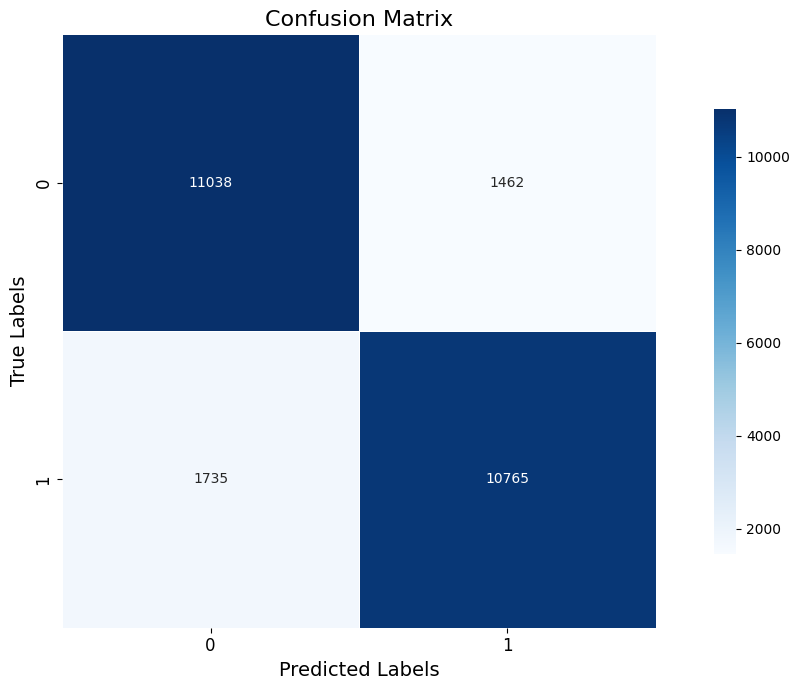

In [85]:
accuracy_metric_test = BinaryAccuracy().to(device)
f1_metric_test = BinaryF1Score().to(device)
CF = BinaryConfusionMatrix().to(device)

with torch.no_grad() :
    for text, label in test_loader_G:
        text, label = text.to(device), label.to(device)

        outputs = model_GLove(text)
        loss = criterion(outputs, label)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        accuracy_metric_test.update(preds, label)
        f1_metric_test.update(preds, label)
        CF.update(preds, label)

print(f"test F1 : {f1_metric_test.compute().item()}\ntest acc : {accuracy_metric_test.compute().item()}" )
creat_heatmap(CF)

# 🧠 Text Classification Model Comparison

### ✅ Dataset: IMDb
### 🔢 Epochs: 5 (TF-IDF & BoW), 13 (GloVe with Early Stopping)

---

## 📘 Model 1: TF-IDF

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score |
|-------|------------|----------|----------|----------|
| 1     | 225.2679   | 43.9643  | 0.8846   | 0.8846   |
| 2     | 140.5007   | 47.5858  | 0.8776   | 0.8801   |
| 3     | 105.0829   | 53.5039  | 0.8728   | 0.8707   |
| 4     | 70.0323    | 62.3517  | 0.8648   | 0.8617   |
| 5     | 40.3958    | 75.8446  | 0.8676   | 0.8698   |

**Test Accuracy:** `0.8512`  
**Test F1 Score:** `0.8519`

---

## 📗 Model 2: Bag of Words (BoW)

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score |
|-------|------------|----------|----------|----------|
| 1     | 232.5238   | 45.8816  | 0.8814   | 0.8822   |
| 2     | 147.8860   | 48.3600  | 0.8788   | 0.8781   |
| 3     | 99.7652    | 54.6962  | 0.8740   | 0.8747   |
| 4     | 59.6355    | 66.9477  | 0.8764   | 0.8765   |
| 5     | 35.8603    | 83.3197  | 0.8682   | 0.8681   |

**Test Accuracy:** `0.8568`  
**Test F1 Score:** `0.8537`

---

## 📙 Model 3: GLoVe Embedding + Neural Net

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Notes                    |
|-------|------------|----------|----------|----------|--------------------------|
| 1     | 340.5047   | 46.3018  | 0.8804   | 0.8770   | Best model saved         |
| 2     | 156.8977   | 45.5134  | 0.8894   | 0.8861   | Best model saved         |
| 3     | 99.0388    | 51.6883  | 0.8946   | 0.8956   | Best model saved         |
| 4     | 70.6183    | 77.2789  | 0.8868   | 0.8913   | No improvement           |
| 5     | 49.1772    | 93.0249  | 0.8878   | 0.8913   | No improvement           |
| 6     | 35.0944    | 78.7330  | 0.8880   | 0.8889   | No improvement           |
| 7     | 35.2670    | 128.5812 | 0.8532   | 0.8390   | No improvement           |
| 8     | 33.0293    | 119.7669 | 0.8830   | 0.8826   | No improvement           |
| 9     | 25.6638    | 141.9652 | 0.8796   | 0.8827   | No improvement           |
| 10    | 18.8682    | 240.9216 | 0.8238   | 0.8452   | No improvement           |
| 11    | 13.4059    | 160.7480 | 0.8754   | 0.8727   | No improvement           |
| 12    | 9.3448     | 166.1631 | 0.8752   | 0.8724   | No improvement           |
| 13    | 4.6410     | 215.0414 | 0.8562   | 0.8666   | Early stopping triggered |

**Best Val F1 Score:** `0.8956` (Epoch 3)  
**Test Accuracy:** `0.8721`  
**Test F1 Score:** `0.8707`

---

## 📊 Summary Comparison

| Model     | Test Accuracy | Test F1 Score | Best Validation F1 Score |
|-----------|---------------|---------------|--------------------------|
| TF-IDF    | 0.8512        | 0.8519        | 0.8846                   |
| BoW       | 0.8568        | 0.8537        | 0.8822                   |
| **GLoVe** | **0.8721**    | **0.8707**    | **0.8956**               |

> ✅ **GLoVe embedding model achieves the best performance** on both validation and test metrics.

